# Import Statements

In [6]:
#from google.colab import drive
#drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge  
from sklearn.pipeline import Pipeline  
from sklearn.preprocessing import StandardScaler, PolynomialFeatures 
from sklearn.metrics import mean_squared_error  

pd.set_option('display.max_columns', 500)
from xgboost import XGBRegressor

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import precision_recall_curve, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay
from IPython.display import Image
import pandas as pd
from functools import reduce
%pip install xgboost
from xgboost import XGBClassifier
from tqdm import tqdm
import math


Note: you may need to restart the kernel to use updated packages.


# Testing and Training Sets and Scaling

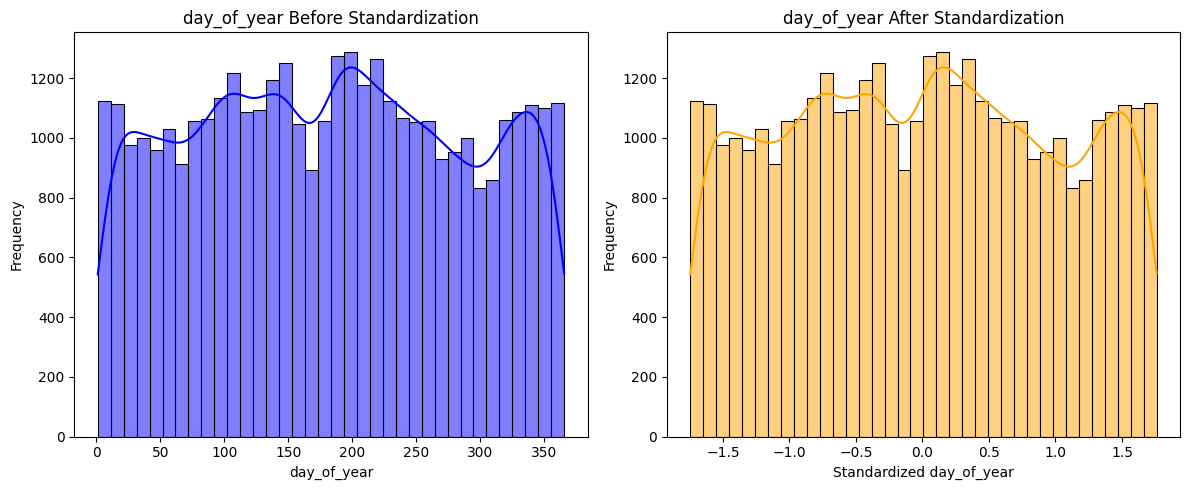

In [7]:
# Load data from CSV file into a DataFrame
file = 'data.csv'
#file =r'/content/drive/MyDrive/Colab Notebooks/dataset.csv'

#read the file
df = pd.read_csv(file)

#convert data_time column to datetime format
df['date_time'] = pd.to_datetime(df['date_time'], format='%m/%d/%Y %H:%M')

#extract specific components of date_time variable so they are int type variables
df['day_of_year'] = df['date_time'].dt.dayofyear #day of number 1-365
df['year'] = df['date_time'].dt.year #year value
df['time'] = df['date_time'].dt.hour #hour of 1-23

#drop original date_time column since we replaced its values
df=df.drop('date_time',axis=1)

#dummy code to make categorial variables binary to be usable
variables_to_dummy = ['holiday', 'weather_main', 'weather_description']
df = pd.get_dummies(df, columns=variables_to_dummy, drop_first=False)

#separate features and target variable
X = df.drop('traffic_volume', axis=1)  
y = df['traffic_volume']  

#split data into training and testing sets, 20% test and 80% train
X_train, X_test, y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Choose a feature to plot
feature_name = 'day_of_year'  # Example feature
feature_idx = X_train.columns.get_loc(feature_name)

# Extract the original and scaled feature values
original_feature = X_train[feature_name]
scaled_feature = X_train_scaled[:, feature_idx]

# Create plots
plt.figure(figsize=(12, 5))

# Plot original feature
plt.subplot(1, 2, 1)
sns.histplot(original_feature, kde=True, color='blue')
plt.title(f'{feature_name} Before Standardization')
plt.xlabel(feature_name)
plt.ylabel('Frequency')

# Plot scaled feature
plt.subplot(1, 2, 2)
sns.histplot(scaled_feature, kde=True, color='orange')
plt.title(f'{feature_name} After Standardization')
plt.xlabel(f'Standardized {feature_name}')
plt.ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

# Visualize the Data and it's Relations

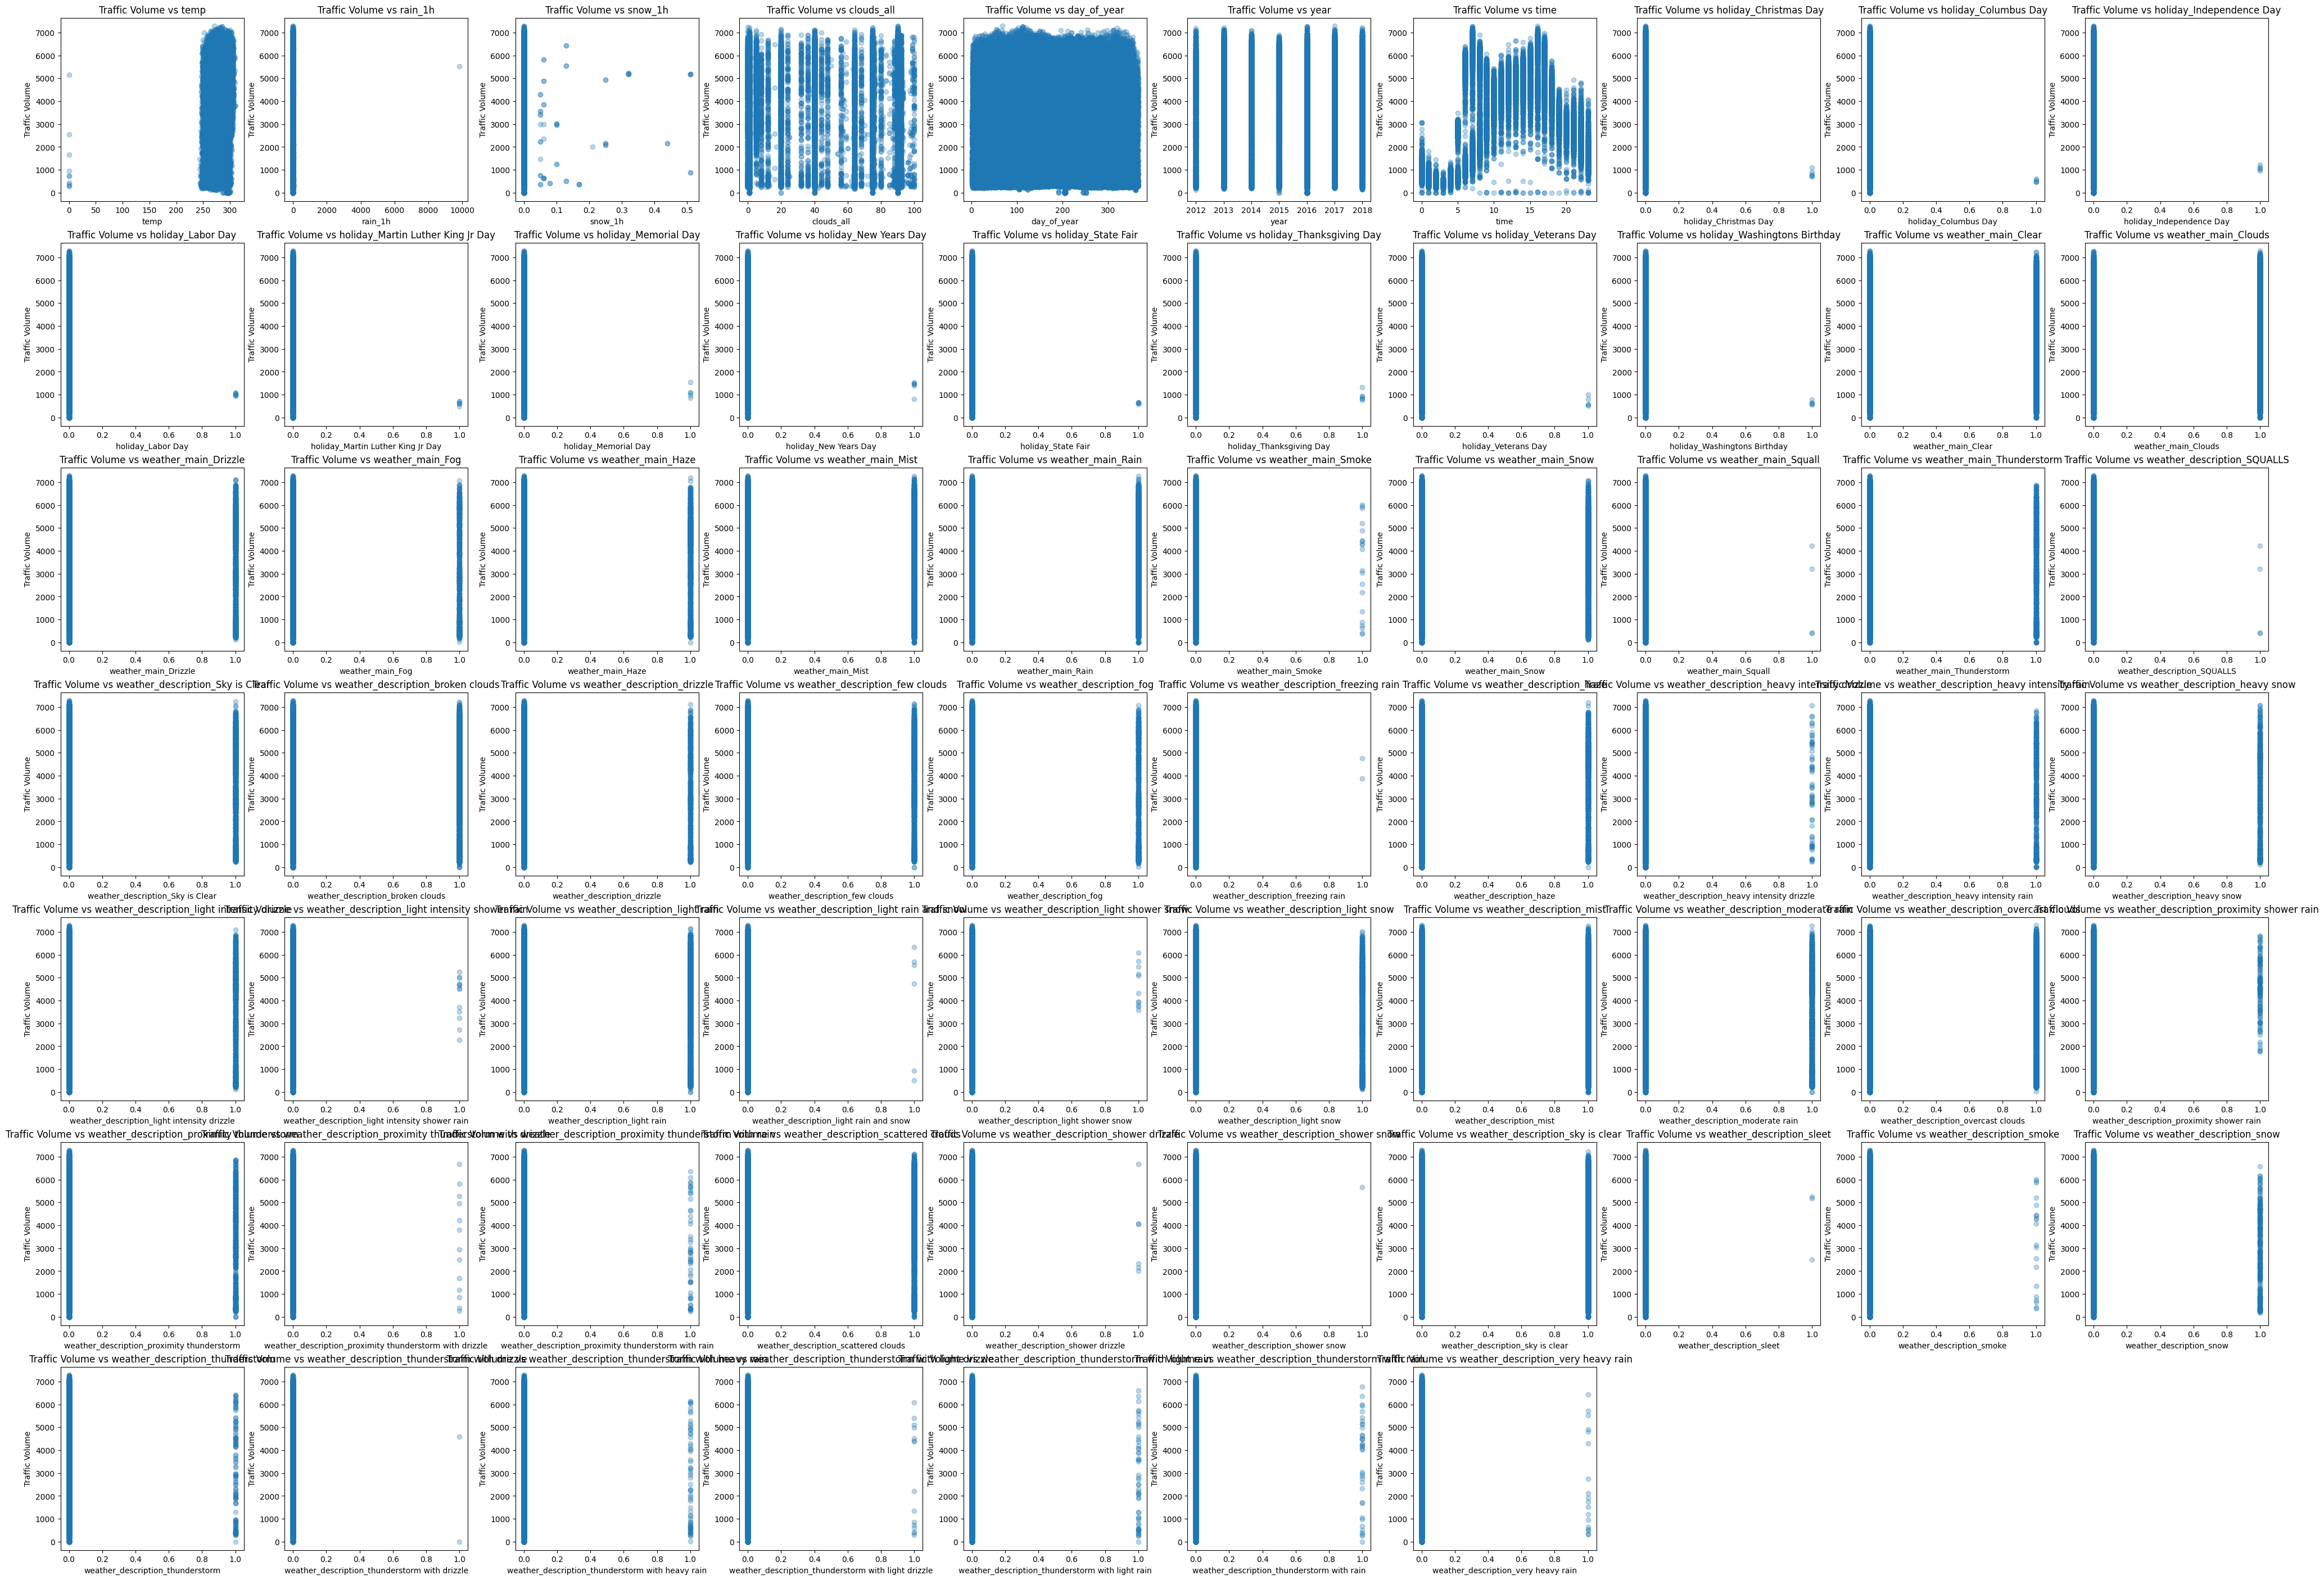

In [8]:
#number of columns per row
plots_per_row = 10

#calculate the total number of rows needed
n_features = len(X.columns)
n_rows = math.ceil(n_features / plots_per_row)

#create subplots
fig, axes = plt.subplots(n_rows, plots_per_row, figsize=(40, 4 * n_rows), constrained_layout=True)

#flatten axes for easier indexing
axes = axes.flatten()

#plot each feature against traffic volume
for i, column in enumerate(X.columns):
    ax = axes[i]
    ax.scatter(X[column], y, alpha=0.3)
    ax.set_xlabel(column)
    ax.set_ylabel('Traffic Volume')
    ax.set_title(f'Traffic Volume vs {column}')

#hide any unused subplots
for i in range(len(X.columns), len(axes)):
    axes[i].set_visible(False)

#show the plots
plt.show()


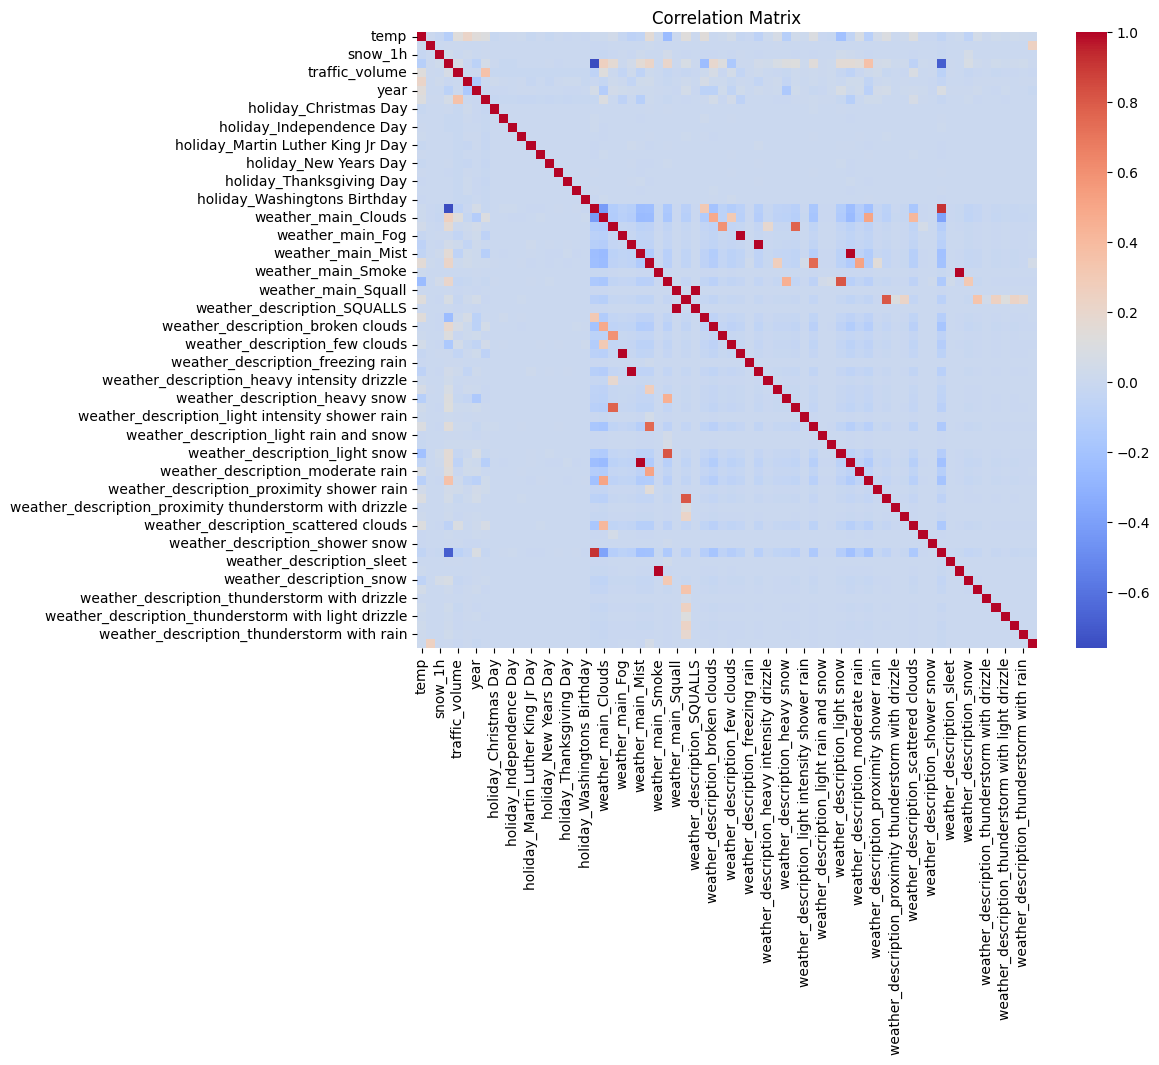

In [9]:
#combine features and target in one DataFrame
df_with_target = df.copy()
df_with_target['traffic_volume'] = y

#compute correlation matrix
corr_matrix = df_with_target.corr()

#plot heatmap of correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

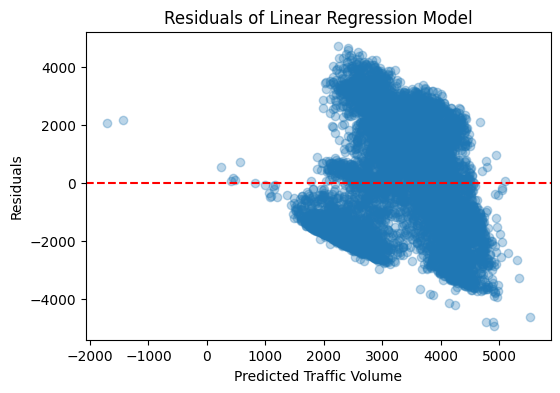

In [10]:
#fit a simple linear regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

#plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Traffic Volume")
plt.ylabel("Residuals")
plt.title("Residuals of Linear Regression Model")
plt.show()

# Finding Different Basic Model Parameters from the Data

In [11]:
#generate polynomial features (degree 2)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

#fit a linear regression model
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

#predict on the test set
y_pred_poly = poly_model.predict(X_test_poly)

#regression metrics
poly_r2 = poly_model.score(X_test_poly, y_test)  # R²
poly_mae = mean_absolute_error(y_test, y_pred_poly)  # MAE
poly_rmse = np.sqrt(mean_squared_error(y_test, y_pred_poly))  # RMSE
poly_mape = np.mean(np.abs((y_test - y_pred_poly) / y_test)) * 100  # MAPE

#convert regression predictions to binary labels for classification metrics
threshold = y_train.mean()  # Example threshold: mean of the training target
y_test_binarized = (y_test > threshold).astype(int)
y_pred_binarized = (y_pred_poly > threshold).astype(int)

#classification metrics
precision = precision_score(y_test_binarized, y_pred_binarized)
recall = recall_score(y_test_binarized, y_pred_binarized)
f1 = f1_score(y_test_binarized, y_pred_binarized)
accuracy = accuracy_score(y_test_binarized, y_pred_binarized)

#print 
print("Polynomial Regression Evaluation Metrics (degree 2):")
print(f"R² (R-squared): {poly_r2:.4f}")
print(f"Mean Absolute Error (MAE): {poly_mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {poly_rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {poly_mape:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Polynomial Regression Evaluation Metrics (degree 2):
R² (R-squared): -11355204273353766912.0000
Mean Absolute Error (MAE): 273203282635.3912
Root Mean Squared Error (RMSE): 6663896403899.4316
Mean Absolute Percentage Error (MAPE): 1306464284940.66%
Precision: 0.8390
Recall: 0.9626
F1 Score: 0.8965
Accuracy: 0.8855


Random Forest Evaluation Metrics:
R² (R-squared): 0.8251
Mean Absolute Error (MAE): 527.7242
Mean Squared Error (MSE): 683891.6588
Root Mean Squared Error (RMSE): 826.9774
Mean Absolute Percentage Error (MAPE): 75.04%
Random Forest Classification Metrics:
Precision: 0.9074
Recall: 0.9529
F1 Score: 0.9296
Accuracy: 0.9256


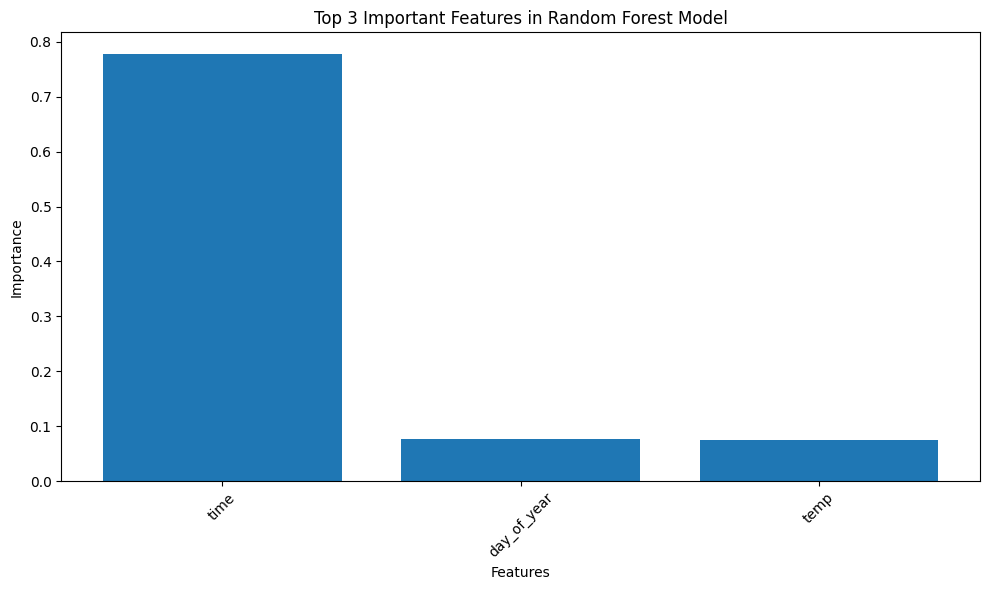


Top 3 Important Features:
time: 0.7783
day_of_year: 0.0758
temp: 0.0754


In [12]:
#initialize and train the Random Forest model
rf_model = RandomForestRegressor(random_state=0)
rf_model.fit(X_train_scaled, y_train)

#predict on the test set
y_pred_rf = rf_model.predict(X_test_scaled)

#calculate evaluation metrics
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_r2 = rf_model.score(X_test_scaled, y_test)  # R-squared
rf_mape = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100  # MAPE

#print
print(f"Random Forest Evaluation Metrics:")
print(f"R² (R-squared): {rf_r2:.4f}")
print(f"Mean Absolute Error (MAE): {rf_mae:.4f}")
print(f"Mean Squared Error (MSE): {rf_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rf_rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {rf_mape:.2f}%")

threshold = y_train.mean() 
y_test_binarized = (y_test > threshold).astype(int)
y_pred_binarized = (y_pred_rf > threshold).astype(int)

#calculate classification metrics
precision = precision_score(y_test_binarized, y_pred_binarized)
recall = recall_score(y_test_binarized, y_pred_binarized)
f1 = f1_score(y_test_binarized, y_pred_binarized)
accuracy = accuracy_score(y_test_binarized, y_pred_binarized)

#print 
print(f"Random Forest Classification Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")




# Get feature importances
importances = rf_model.feature_importances_
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Select top 3 features
top_3_features = feature_importances.head(3)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(top_3_features['feature'], top_3_features['importance'])
plt.title('Top 3 Important Features in Random Forest Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print the top 3 features and their importance scores
print("\nTop 3 Important Features:")
for index, row in top_3_features.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

In [13]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),  #first hidden layer
    Dropout(0.2),  #dropout layer
    Dense(64, activation='relu'),  #second hidden layer
    Dropout(0.2),
    Dense(64, activation='relu'),  #third hidden layer
    Dense(32, activation='relu'),  #fourth hidden layer
    Dense(16, activation='relu'),  #fifth hidden layer
    Dense(1)  #output layer
])

#compile model
model.compile(optimizer='adam', loss='mse')

#train model with 50 epochs
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

#predict on the test set
y_pred_nn = model.predict(X_test_scaled).flatten()

#calculate metrics
nn_mse = mean_squared_error(y_test, y_pred_nn)
print(f"Neural Network MSE: {nn_mse}")
r2 = r2_score(y_test, y_pred_nn)
print(f"Neural Network R²: {r2}")
nn_mae = mean_absolute_error(y_test, y_pred_nn)
print(f"Neural Network MAE: {nn_mae}")
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
nn_mape = mean_absolute_percentage_error(y_test, y_pred_nn)
print(f"Neural Network MAPE: {nn_mape}%")

#convert regression predictions to binary labels for classification metrics
threshold = y_train.mean()  
y_test_binarized = (y_test > threshold).astype(int)
y_pred_binarized = (y_pred_nn > threshold).astype(int)

#calculate classification metrics
precision = precision_score(y_test_binarized, y_pred_binarized,average='weighted')
recall = recall_score(y_test_binarized, y_pred_binarized)
f1 = f1_score(y_test_binarized, y_pred_binarized)
accuracy = accuracy_score(y_test_binarized, y_pred_binarized)

#print
print("Neural Network Classification Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

c:\Users\bvive\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6788729.5000 - val_loss: 3397131.7500
Epoch 2/50
965/965 ━━━━━━━━━━━━━━━━━━━━ 1s 918us/step - loss: 3484733.2500 - val_loss: 3634416.7500
Epoch 3/50
965/965 ━━━━━━━━━━━━━━━━━━━━ 1s 905us/step - loss: 3511101.7500 - val_loss: 2846334.5000
Epoch 4/50
965/965 ━━━━━━━━━━━━━━━━━━━━ 1s 965us/step - loss: 2813377.5000 - val_loss: 1301258.7500
Epoch 5/50
965/965 ━━━━━━━━━━━━━━━━━━━━ 1s 885us/step - loss: 1697080.8750 - val_loss: 1114498.8750
Epoch 6/50
965/965 ━━━━━━━━━━━━━━━━━━━━ 1s 878us/step - loss: 1503335.7500 - val_loss: 1046105.6250
Epoch 7/50
965/965 ━━━━━━━━━━━━━━━━━━━━ 1s 856us/step - loss: 1477914.7500 - val_loss: 1023976.7500
Epoch 8/50
965/965 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step - loss: 1410979.1250 - val_loss: 1067027.8750
Epoch 9/50
965/965 ━━━━━━━━━━━━━━━━━━━━ 1s 907us/step - loss: 1337133.7500 - val_loss: 1084509.2500
Epoch 10/50
965/965 ━━━━━━━━━━━━━━━━━━━━ 1s 889us/step - loss: 1337419.3750 - val_loss: 1166974.8750
E

In [14]:
#scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#initialize and train the XGBoost model
xgb_model = XGBRegressor(random_state=0)
xgb_model.fit(X_train_scaled, y_train)

#predict and evaluate
y_pred_xgb = xgb_model.predict(X_test_scaled)

#calculate metrics
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
print(f"XGBoost MSE: {xgb_mse}")
r2 = r2_score(y_test, y_pred_xgb)
print(f"XGBoost R²: {r2}")
mae = mean_absolute_error(y_test, y_pred_xgb)
print(f"XGBoost MAE: {mae}")
rmse = np.sqrt(xgb_mse)
print(f"XGBoost RMSE: {rmse}")
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_test, y_pred_xgb)
print(f"XGBoost MAPE: {mape}%")

#convert regression predictions to binary labels for classification metrics
threshold = y_train.mean()  
y_test_binarized = (y_test > threshold).astype(int)
y_pred_binarized = (y_pred_xgb > threshold).astype(int)

#calculate classification metrics
precision = precision_score(y_test_binarized, y_pred_binarized)
recall = recall_score(y_test_binarized, y_pred_binarized)
f1 = f1_score(y_test_binarized, y_pred_binarized)
accuracy = accuracy_score(y_test_binarized, y_pred_binarized)
#print
print("XGBoost Classification Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")


XGBoost MSE: 633090.7227744651
XGBoost R²: 0.8381158113479614
XGBoost MAE: 531.7354614576627
XGBoost RMSE: 795.6699835826818
XGBoost MAPE: 72.04497992247418%
XGBoost Classification Metrics:
Precision: 0.8992
Recall: 0.9589
F1 Score: 0.9281
Accuracy: 0.9235


# Using Unsupervised

K = 40, Silhouette Score = 0.576, Davies-Bouldin Score = 0.412
K = 41, Silhouette Score = 0.587, Davies-Bouldin Score = 0.372
K = 42, Silhouette Score = 0.588, Davies-Bouldin Score = 0.366
K = 43, Silhouette Score = 0.520, Davies-Bouldin Score = 0.406
K = 44, Silhouette Score = 0.521, Davies-Bouldin Score = 0.399
K = 45, Silhouette Score = 0.522, Davies-Bouldin Score = 0.393
K = 46, Silhouette Score = 0.523, Davies-Bouldin Score = 0.387
K = 47, Silhouette Score = 0.525, Davies-Bouldin Score = 0.381
K = 48, Silhouette Score = 0.526, Davies-Bouldin Score = 0.376
K = 49, Silhouette Score = 0.528, Davies-Bouldin Score = 0.371
K = 50, Silhouette Score = 0.531, Davies-Bouldin Score = 0.367
K = 51, Silhouette Score = 0.495, Davies-Bouldin Score = 0.419
K = 52, Silhouette Score = 0.496, Davies-Bouldin Score = 0.400
K = 53, Silhouette Score = 0.489, Davies-Bouldin Score = 0.414
K = 54, Silhouette Score = 0.453, Davies-Bouldin Score = 0.453
K = 55, Silhouette Score = 0.434, Davies-Bouldin Score 

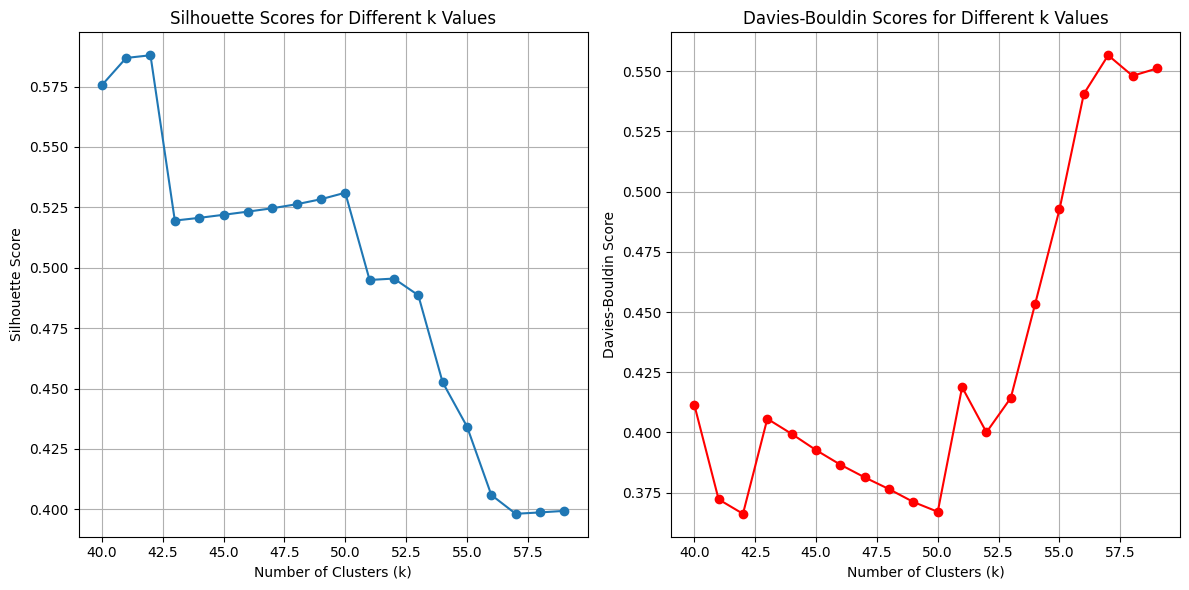

In [15]:
def evaluate_clustering(X_train_scaled):
    k_values = range(40,60, 1)
    silhouette_scores = []
    davies_bouldin_scores = []
 
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(X_train_scaled)
 
        #calculate silhouette score
        silhouette_avg = silhouette_score(X_train_scaled, cluster_labels)
        silhouette_scores.append(silhouette_avg)
 
        #calculate Davies-Bouldin score
        db_score = davies_bouldin_score(X_train_scaled, cluster_labels)
        davies_bouldin_scores.append(db_score)
 
        print(f"K = {k}, Silhouette Score = {silhouette_avg:.3f}, Davies-Bouldin Score = {db_score:.3f}")
 
    #plot scores
    plt.figure(figsize=(12, 6))
   
    plt.subplot(1, 2, 1)
    plt.plot(k_values, silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Different k Values')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
 
    plt.subplot(1, 2, 2)
    plt.plot(k_values, davies_bouldin_scores, marker='o', color='r')
    plt.title('Davies-Bouldin Scores for Different k Values')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Davies-Bouldin Score')
    plt.grid(True)
 
    plt.tight_layout()
    plt.show()
 
#evaluate clustering with different k values
evaluate_clustering(X_train_scaled)

Silhouette Score: 0.5879718095508254
Davies-Bouldin Score: 0.3662474134116707


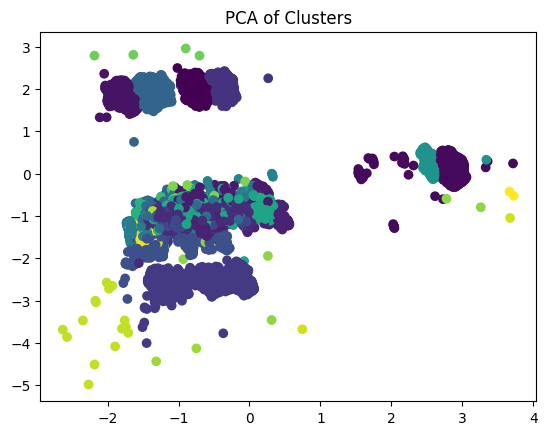

In [16]:
from sklearn.cluster import KMeans

k = 42  

kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_train_scaled)

#predict the cluster labels for each point
cluster_labels = kmeans.labels_

#calculate the MSE: the squared Euclidean distance between each point and its cluster center
squared_distances = np.zeros(X_train.shape[0])
for i in range(X_train_scaled.shape[0]):
    center = kmeans.cluster_centers_[cluster_labels[i]]
    squared_distances[i] = np.sum((X_train_scaled[i] - center) ** 2)  # Correct indexing

#calculate metrics
silhouette_avg = silhouette_score(X_train_scaled, cluster_labels)
print(f'Silhouette Score: {silhouette_avg}')
db_score = davies_bouldin_score(X_train_scaled, cluster_labels)
print(f'Davies-Bouldin Score: {db_score}')
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels)
plt.title('PCA of Clusters')
plt.show()

In [17]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, precision_score, recall_score, f1_score, accuracy_score
from scipy.optimize import linear_sum_assignment
import numpy as np

#assume true labels for the test set
true_labels_test = y_test 
predicted_labels = kmeans.predict(X_test_scaled)

#match clusters to true labels using the Hungarian Algorithm
def match_clusters_to_labels(true_labels, predicted_labels):
    max_label = max(true_labels.max(), predicted_labels.max()) + 1
    cost_matrix = np.zeros((max_label, max_label))
    for true, pred in zip(true_labels, predicted_labels):
        cost_matrix[true, pred] -= 1  
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    label_map = {col: row for row, col in zip(row_ind, col_ind)}
    return np.array([label_map[label] for label in predicted_labels])

#map the cluster labels to the true labels
mapped_labels = match_clusters_to_labels(true_labels_test, predicted_labels)

#compute regression metrics
mse = mean_squared_error(true_labels_test, mapped_labels)
r2 = r2_score(true_labels_test, mapped_labels)
mae = mean_absolute_error(true_labels_test, mapped_labels)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((true_labels_test - mapped_labels) / true_labels_test)) * 100

#compute classification metrics
threshold = y_train.mean()  
y_test_binarized = (true_labels_test > threshold).astype(int)
mapped_labels_binarized = (mapped_labels > threshold).astype(int)

precision = precision_score(y_test_binarized, mapped_labels_binarized)
recall = recall_score(y_test_binarized, mapped_labels_binarized)
f1 = f1_score(y_test_binarized, mapped_labels_binarized)
accuracy = accuracy_score(y_test_binarized, mapped_labels_binarized)

#print
print("Clustering Metrics:")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print("Clustering Classification Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")


Clustering Metrics:
MSE: 11224917.0255
R²: -1.8703
MAE: 2728.4789
RMSE: 3350.3607
MAPE: 141.51%
Clustering Classification Metrics:
Precision: 0.6730
Recall: 0.0994
F1 Score: 0.1732
Accuracy: 0.5109


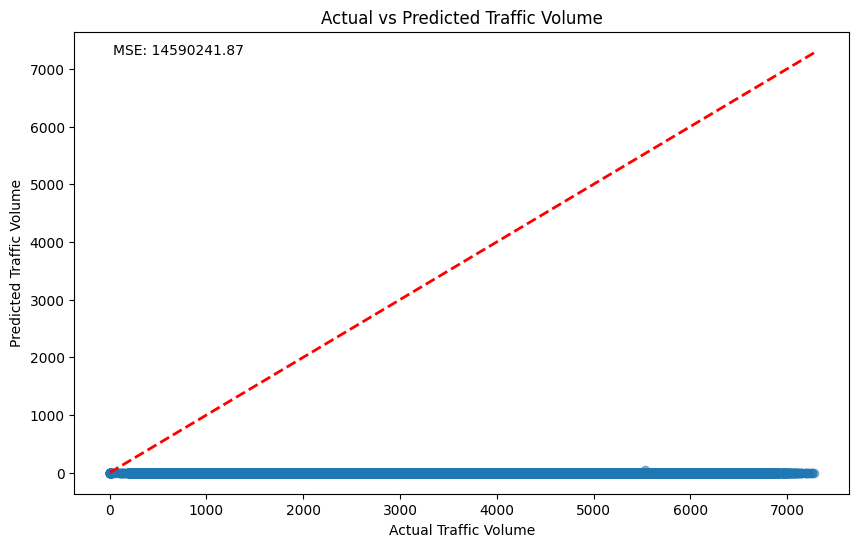


Sample comparisons of Actual vs Predicted Traffic Volume:
Actual: 5583, Predicted: -0
Actual: 528, Predicted: -0
Actual: 6223, Predicted: 0
Actual: 4714, Predicted: -0
Actual: 4518, Predicted: -0
Actual: 363, Predicted: -0
Actual: 1447, Predicted: -0
Actual: 5517, Predicted: -0
Actual: 4693, Predicted: -0
Actual: 1811, Predicted: -0


In [19]:
#find cluster centers
cluster_centers = kmeans.cluster_centers_
traffic_volume_centers = cluster_centers[:, -1]  
 
# predict values using clusters
predicted_traffic = np.zeros(X_train.shape[0])
for i in range(X_train.shape[0]):
    predicted_traffic[i] = traffic_volume_centers[cluster_labels[i]]
 
#get the true values
actual_traffic = y_train.values
 
#find mse between the two values
mse = mean_squared_error(actual_traffic, predicted_traffic)
 
#plot graph
plt.figure(figsize=(10, 6))
plt.scatter(actual_traffic, predicted_traffic, alpha=0.5)
plt.plot([actual_traffic.min(), actual_traffic.max()], [actual_traffic.min(), actual_traffic.max()], 'r--', lw=2)
plt.xlabel('Actual Traffic Volume')
plt.ylabel('Predicted Traffic Volume')
plt.title('Actual vs Predicted Traffic Volume')
plt.text(0.05, 0.95, f'MSE: {mse:.2f}', transform=plt.gca().transAxes)
plt.show()
 
#display sample comparisons
print("\nSample comparisons of Actual vs Predicted Traffic Volume:")
for i in range(10):
    print(f"Actual: {actual_traffic[i]:.0f}, Predicted: {predicted_traffic[i]:.0f}")